In [1]:
#Importing Libraries
import tensorflow as tf #open source library for machine learning and it is end to end
from tensorflow.keras.utils import img_to_array,array_to_img,load_img #Public Keras utilities
from skimage.io import imsave #Skimage reads the image, converts it from JPEG into a NumPy array, and returns the array
import numpy as np #for working with arrays
from skimage import color
import os #for opening files etc
import random
from PIL import Image

In [3]:
#Getting Images
X = []

for imagename in os.listdir('Dataset/Train/'):#takes the filename of all images
    image = Image.open('Dataset/Train/'+imagename) #reads the image
    new_image = image.resize((256, 256)) #resizes the image to 256x256
    new_image.save('Dataset/Train/'+imagename)
    X.append(img_to_array(load_img('Dataset/Train/'+imagename)))#takes every image in directory and loads it and then convert to array and add it into the list
X = np.array(X, dtype=float) #converts X which is a list to array and changes datatype to float


# Set up train and test data

split = int(0.95*len(X)) #splitting the data 
Xtrain = X[:split] 
Xtrain = 1.0/255*Xtrain #normalization of training data to standardize data and it improves the accuracy and integrity of your data

In [4]:
#CNN model

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Sequential

model = Sequential() #Sequential is the easiest way to build a model in Keras. It allows you to build a model layer by layer.one input one output

#Input Layer

model.add(Conv2D(64, (3, 3), input_shape=(256, 256, 1), activation='relu', padding='same'))#input shape 3 tuples so 3 dimensions 256,256 is the pixels


#Hidden Layers

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))#rectified linear is the most used activation function for all CNN models.we use relu because it helps prevent expotential growth in computation.
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))#Conv2D is convolution layer this layer creates a convolution kernel
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))# the number of pixels shifts over the input matrix. When the stride is 1 then we move the filters to 1 pixel at a time.
BatchNormalization()
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))#padding can be either valid or same. same means padding with zeros evenly
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))#512 is the numbers of filters that convolutional layers will learn from.(3,3) is the kernel size the number must be odd
BatchNormalization()
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))#a simple scaling up of the image by using nearest neighbour or bilinear upsampling, so nothing smart. Advantage is it's cheap.(2,2) is the size indicating no. of columns and rows.
BatchNormalization()#It is done along mini-batches instead of the full data set. It serves to speed up training and use higher learning rates, making learning easier.
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
BatchNormalization()
model.add(UpSampling2D((2, 2)))
#Compiling the CNN

model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])#RMSProp uses the second moment by with a decay rate to speed up from AdaGrad. Adam uses both first and second moments of the gradient, and is generally the best choice
#we tried adam and rmsprop and sgd adam is better than sgd for cnn as its more efficent
#loss is measured with mean squared error
#metrics used to judge performance of model

30/30 [==============================] - 70s 2s/step - loss: 0.2581 - accuracy: 0.4838


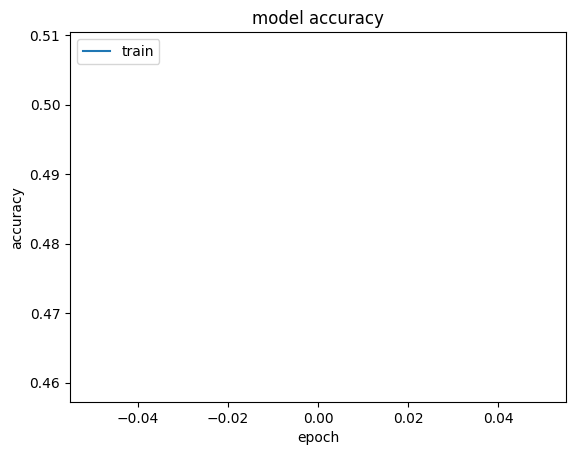

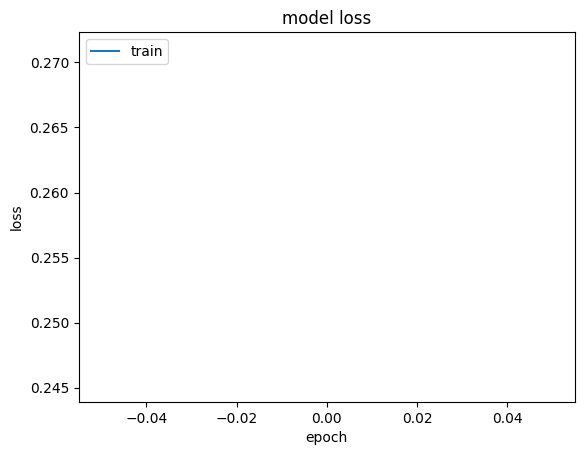

In [5]:
import matplotlib.pyplot as plt
# Image augmentation helps in improving size of training set without getting new images and help improve prediction
# Image transformer
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True)#image data generation takes the original data and transforms based on parameters passed and adds this data to the original data and runs this.This is called data augmention.

# Generate training data
batch_size = 10
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):  #datagen.flow generates batches of tensor images with real-time data augmentation(artificially increasing amount of data)
        lab_batch = color.rgb2lab(batch) #converts training piture from rbg to lab colorspace. it needs a 3d array as input [[[0.1,0.2,0.3]]]
        X_batch = lab_batch[:,:,:,0] #L channel
        Y_batch = lab_batch[:,:,:,1:] / 128 #ab channel, the two batches are the splitting of lab colors for prevention of overfitting
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch) #The reason for reshaping is to ensure that the input data to the model is in the correct shape

# Train model      
tensorboard = TensorBoard(log_dir="/output/beta_run")
trainedmodel = model.fit(image_a_b_gen(batch_size), callbacks=[tensorboard],epochs=1, steps_per_epoch=30)


# summarize history for accuracy
plt.plot(trainedmodel.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(trainedmodel.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [6]:
# Save model

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [7]:
# load json and create model

from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [ ]:
loaded_model.summary()

Output of the Model
1/1 [==============================] - 2s 2s/step


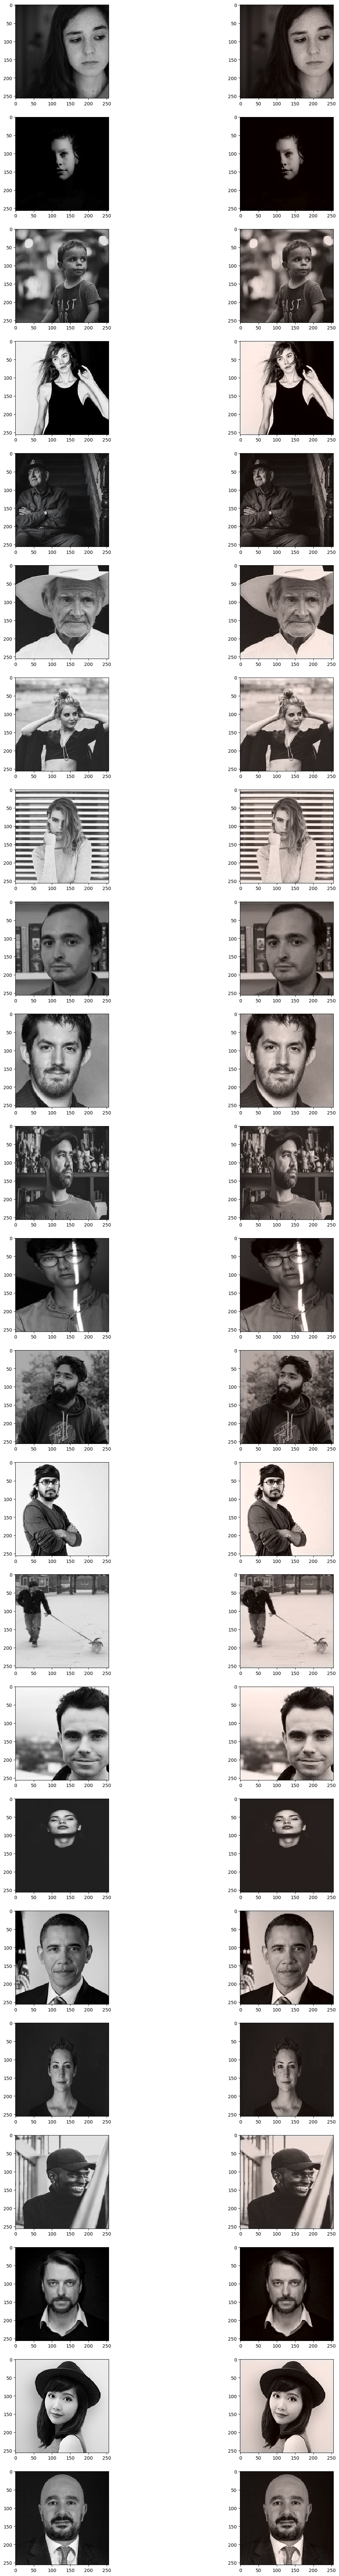

In [8]:
# Manual Testing of Images

import cv2
import os
%matplotlib inline 
from matplotlib import pyplot as plt #sets the backend of matplotlib to inline (shows the plots in the jupyter notebook)

fig, ax = plt.subplots(23, 2, figsize=(16,100)) #returns a tuple containing fig and axes objects, 23,2 = rows,columns.. if 3,2.. then axes will be like [[ax1,ax2],[ax3,ax4],[ax5,ax6]]
row = 0
colorize = []
print('Output of the Model')
for filename in os.listdir('Dataset/Test/'): #gets all the files in the entered directory
	image = Image.open('Dataset/Test/'+filename) #reads the image
	new_image = image.resize((256, 256)) #resizes the image to 256x256
	new_image.save('Dataset/Test/'+filename)
	colorize.append(img_to_array(load_img('Dataset/Test/'+filename))) #load_img reads the image from the file and then it is converted into a numpy array 
	ax[row,0].imshow(load_img('Dataset/Test/'+filename), interpolation='nearest') #imshow is openCV func to display img in window
	row +=1 #interpolate is when we try to estimate unknown data points b/w two data points, interpolation = nearest displays the img without trying to interpolate b/w pixels

colorize = np.array(colorize, dtype=float) #converts the image array to float values
colorize = color.rgb2lab(1.0/255*colorize)[:,:,:,0] #L space of the Lab colorspace
colorize = colorize.reshape(colorize.shape+(1,)) #.shape() gives the shape of the numpy array, (no. of arrays, no. of values in each array)
#reshapes colorize to include one more array 

# Test model
output = loaded_model.predict(colorize) #predicts the labels of the data values based on the trained model
output = output * 128 #to get the true color value in Lab colorspace(ranges between -128 to 128)
row = 0

# Output colorizations
for i in range(len(output)):
	cur = np.zeros((256, 256, 3)) #creates a black background
	cur[:,:,0] = colorize[i][:,:,0] #copy grayscale layer from test image
	cur[:,:,1:] = output[i] #add other two color layers
	resImage = color.lab2rgb(cur) 
	ax[row,1].imshow(resImage, interpolation='nearest') #display the image on the notebook
	row += 1
    

# 	imsave("result/img_"+str(i)+".png", resImage)
    
    